# 📚 Import Libraries

In [1]:
import folium
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Tuple, Optional, Any, Dict

from IPython.display import display
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import ParameterGrid

# Class Functions

## 🏙️ City Data

A class to handle city data and distance calculations.

In [2]:
class CityData:
    """A class to handle city data and distance calculations."""

    def __init__(self, csv_path: str):
        """Initialize CityData with a CSV file path."""
        self.capital: pd.DataFrame = pd.read_csv(csv_path)
        self.distances: np.ndarray = self._calculate_distances()

    def _haversine(self, lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """Calculate the distance between two points using the Haversine formula."""
        R: int = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon: float = lon2 - lon1
        dlat: float = lat2 - lat1
        a: float = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c: float = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

    def _calculate_distances(self) -> np.ndarray:
        """Calculate the distance matrix between all capital cities."""
        n_cities: int = len(self.capital)
        distances: np.ndarray = np.zeros((n_cities, n_cities))
        for i in range(n_cities):
            for j in range(n_cities):
                if i != j:
                    distances[i, j] = self._haversine(
                        self.capital.latitude[i],
                        self.capital.longitude[i],
                        self.capital.latitude[j],
                        self.capital.longitude[j],
                    )
        return distances

    def get_map_center(self) -> List[float]:
        """Get the center coordinates for map display."""
        return [self.capital["latitude"].mean(), self.capital["longitude"].mean()]

    def print_head(self) -> None:
        """Print the head of dataframe"""
        print("First 5 rows of the data:")
        print(self.capital.head())

    def print_info(self) -> None:
        """Print information of data"""
        print(f"Number of capital cities: {len(self.capital)}")

    def get_city_coordinates(self, index: int) -> Tuple[float, float]:
        """Get the latitude and longitude of the city"""
        return self.capital.latitude[index], self.capital.longitude[index]

    def get_city_name(self, index: int) -> str:
        """Get the name of the city"""
        return self.capital.capital[index]
    
    def get_province_name(self, index: int) -> str:
        """Get the name of the province"""
        return self.capital.province[index]

## 🌍 Map Visualizer

A class to handle map visualization.

In [3]:
class MapVisualizer:
    """A class to handle map visualization."""

    def __init__(self, city_data: CityData):
        """Initialize MapVisualizer with city data."""
        self.city_data: CityData = city_data

    def display_initial_map(self) -> None:
        """Display the initial map with capital city markers."""
        map_center: List[float] = self.city_data.get_map_center()
        my_map: folium.Map = folium.Map(location=map_center, zoom_start=4)
        for _, row in self.city_data.capital.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=f"{row['capital']}, {row['province']}",
                icon=folium.CustomIcon("images/icon.png", icon_size=(20, 20)),
            ).add_to(my_map)
        print("Initial map of capital cities:")
        display(my_map)

    def visualize_path(self, path: List[int]) -> None:
        """Visualize the best path on a map."""
        map_center: List[float] = self.city_data.get_map_center()
        my_map: folium.Map = folium.Map(location=map_center, zoom_start=4)
        points: List[tuple[float,float]] = [self.city_data.get_city_coordinates(i) for i in path]
        folium.PolyLine(points, weight=3, color='red').add_to(my_map)
        
        for i, city_index in enumerate(path):
            city_name: str = self.city_data.get_city_name(city_index)
            province_name: str = self.city_data.get_province_name(city_index)
            lat: float
            lon: float
            lat, lon = self.city_data.get_city_coordinates(city_index)
            folium.Marker(
                [lat, lon], 
                popup=f"[{i+1}] {city_name}, {province_name}.",
                icon=folium.CustomIcon("images/icon.png", icon_size=(20, 20)),
                ).add_to(my_map)
        print("\nVisualizing the best path...")
        display(my_map)

## 🌐 Distance Visualizer

A class to handle distance matrix visualization.

In [4]:
class DistanceVisualizer:
    """A class to handle distance matrix visualization."""

    def __init__(self, distances: np.ndarray, city_data: CityData):
        """Initialize DistanceVisualizer with distance data and city data."""
        self.distances: np.ndarray = distances
        self.city_data: CityData = city_data

    def annotate_km(self, data: np.ndarray, **kws: Any) -> None:
        """Annotate a heatmap with distances in kilometers."""
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(
                    j + 0.5,
                    i + 0.5,
                    f"{data[i, j]:.0f} km",
                    ha="center",
                    va="center",
                    color="white",
                )

    def display_distance_matrix(self, start_index: int = 10, end_index: int = 16) -> None:
        """Display a sample of the distance matrix."""
        sample_distances: np.ndarray = self.distances[start_index:end_index, start_index:end_index]
        print("\nSample distance matrix (5x5):")
        print(sample_distances)

    def display_distance_heatmap(self, start_index: int = 10, end_index: int = 16) -> None:
        """Display a heatmap of the distance matrix."""
        sample_distances: np.ndarray = self.distances[start_index:end_index, start_index:end_index]
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(
            sample_distances,
            cmap="viridis",
            annot=False,
            xticklabels=self.city_data.capital["capital"][start_index:end_index],
            yticklabels=self.city_data.capital["capital"][start_index:end_index],
        )
        self.annotate_km(sample_distances)
        plt.title("Distance Matrix Heatmap")
        plt.xlabel("City")
        plt.ylabel("City")
        plt.show()

## 🐜 Ant Colony Optimizer

A class to implement the Ant Colony Optimization algorithm.

In [5]:
class AntColonyOptimizer:
    """A class to implement the Ant Colony Optimization algorithm."""

    def __init__(
        self,
        distances: np.ndarray,
        n_ants: int,
        n_iterations: int,
        decay_rate: float = 0.5,
        alpha: float = 1,
        beta: float = 5,
        q: int = 1,
    ):
        """Initialize the ACO parameters."""
        self.distances: np.ndarray = distances
        self.n_cities: int = len(distances)
        self.n_ants: int = n_ants
        self.n_iterations: int = n_iterations
        self.decay_rate: float = decay_rate
        self.alpha: float = alpha
        self.beta: float = beta
        self.q: int = q
        self.pheromone: np.ndarray = np.ones((self.n_cities, self.n_cities))
        self.best_path: Optional[List[int]] = None
        self.best_path_length: float = float("inf")

    def _select_next_city(self, current_city: int, visited: np.ndarray) -> int:
        """Select the next city based on pheromone and distance."""
        unvisited: np.ndarray = np.where(visited == False)[0]
        probabilities: List[float] = []
        total_prob: float = 0

        for city in unvisited:
            eta: float = (
                1 / self.distances[current_city][city]
                if self.distances[current_city][city] > 0
                else 0
            )
            tau: float = self.pheromone[current_city][city]
            prob: float = (tau**self.alpha) * (eta**self.beta)
            probabilities.append(prob)
            total_prob += prob

        if total_prob == 0:
            return random.choice(unvisited)
        probabilities = np.array(probabilities) / total_prob
        return np.random.choice(unvisited, p=probabilities)

    def _move_ant(self, start_city: int) -> List[int]:
        """Move an ant and return a path."""
        current_city: int = start_city
        visited: np.ndarray = np.zeros(self.n_cities, dtype=bool)
        visited[current_city] = True
        path: List[int] = [current_city]

        for _ in range(self.n_cities - 1):
            next_city: int = self._select_next_city(current_city, visited)
            path.append(next_city)
            visited[next_city] = True
            current_city = next_city
        path.append(start_city)
        return path

    def _calculate_path_length(self, path: List[int]) -> float:
        """Calculate the total length of a path."""
        length: float = 0
        for i in range(len(path) - 1):
            length += self.distances[path[i]][path[i + 1]]
        return length

    def _update_pheromones(self, paths: List[List[int]]) -> None:
        """Update the pheromone trails based on ant paths."""
        self.pheromone *= 1 - self.decay_rate

        for path in paths:
            path_length: float = self._calculate_path_length(path)
            for i in range(len(path) - 1):
                delta_pheromone: float = self.q / path_length if path_length > 0 else 0
                self.pheromone[path[i]][path[i + 1]] += delta_pheromone

    def optimize(self) -> List[int]:
        """Run the ACO optimization algorithm."""
        for i in range(self.n_iterations):
            paths: List[List[int]] = []
            for _ in range(self.n_ants):
                start_city: int = random.randint(0, self.n_cities - 1)
                paths.append(self._move_ant(start_city))
            self._update_pheromones(paths)
            for path in paths:
                path_length: float = self._calculate_path_length(path)
                if path_length < self.best_path_length:
                    self.best_path = path
                    self.best_path_length = path_length
            if i % 10 == 0:
                print(f"Iteration {i+1}: Best path length = {self.best_path_length}")
        return self.best_path

## 🔧 Hyperparameter Optimizer

A class to handle hyperparameter optimization for ACO.

In [6]:
class HyperparameterOptimizer:
    """A class to handle hyperparameter optimization for ACO."""

    def __init__(self, distances: np.ndarray):
        """Initialize HyperparameterOptimizer with distance data."""
        self.distances: np.ndarray = distances

    def _aco_fitness(self, params: Dict[str, Any]) -> float:
        """Fitness function to evaluate ACO parameters."""
        n_ants: int = params["n_ants"]
        n_iterations: int = params["n_iterations"]
        decay_rate: float = params["decay_rate"]
        alpha: float = params["alpha"]
        beta: float = params["beta"]
        aco: AntColonyOptimizer = AntColonyOptimizer(
            self.distances, n_ants, n_iterations, decay_rate, alpha, beta
        )
        best_path = aco.optimize()
        best_path_length: float = aco._calculate_path_length(best_path)
        return 1 / best_path_length if best_path_length > 0 else 0

    def optimize(self, param_grid: Optional[Dict[str, List[Any]]] = None) -> Dict[str, Any]:
        """Optimize ACO hyperparameters using ParameterGrid."""
        if param_grid is None:
            param_grid: Dict[str, List[Any]] = {
                "n_ants": [20],
                "n_iterations": [100],
                "decay_rate": [0.2],
                "alpha": [1],
                "beta": [3],
            }
        
        best_score: float = 0
        best_params: Optional[Dict[str, Any]] = None
        grid: ParameterGrid = ParameterGrid(param_grid)
        for params in grid:
            score: float = self._aco_fitness(params)
            print(f"Params : {params} | Score : {score}")
            if score > best_score:
                best_score = score
                best_params = params
        print(f"\nBest Hyperparameters: {best_params} with score: {best_score}")
        return best_params

## 🎉 Result Display

A class to handle displaying the final results.

In [7]:
class ResultDisplay:
    """A class to handle displaying the final results."""

    def __init__(self, city_data: CityData, distances: np.ndarray):
        """Initialize ResultDisplay with city data and distances."""
        self.city_data: CityData = city_data
        self.distances: np.ndarray = distances

    def display_result(self, path: List[int]) -> None:
        """Display the sequence of visited cities with distances in a table."""
        data: List[List[str]] = []
        total_distance: float = 0
        
        for i in range(len(path) - 1):
            current_city_index: int = path[i]
            next_city_index: int = path[i+1]
            
            current_city_name: str = self.city_data.get_city_name(current_city_index)
            current_province_name: str = self.city_data.get_province_name(current_city_index)
            
            distance: float = self.distances[current_city_index][next_city_index]
            total_distance += distance

            data.append([f"{i+1:02d}", current_city_name, current_province_name, f"{distance:.2f} km"]) # added string format on number
        
        df: pd.DataFrame = pd.DataFrame(data, columns=["Number", "City Name", "Province Name", "Distance (km)"])
        display(df)
        print(f"\nTotal distance: {total_distance:.2f} km")

# Call Class Functions

## Data Initialization

### 🔢 Number of Capital Cities

In [8]:
city_data = CityData("data/capital.csv")
city_data.print_info()

Number of capital cities: 38


### 🌟 First 5 rows of The Data

In [9]:
city_data.print_head()

First 5 rows of the data:
         province     capital  latitude  longitude
0            Aceh  Banda Aceh      5.55      95.32
1  Sumatera Utara       Medan      3.58      98.67
2  Sumatera Barat      Padang     -0.94     100.36
3            Riau   Pekanbaru      0.54     101.44
4           Jambi       Jambi     -1.60     103.61


## Map and Distance Visualization

### 🌍 Map Visualizer

Initial map of capital cities:



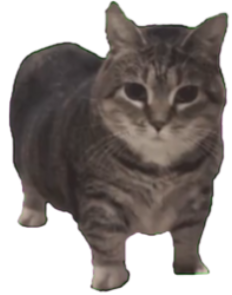
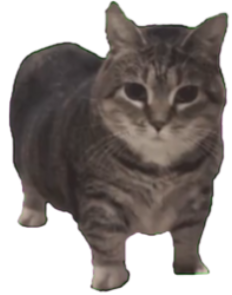
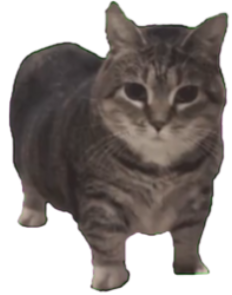
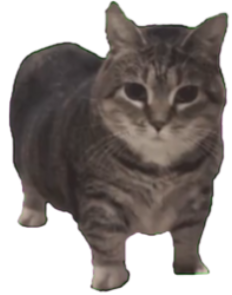
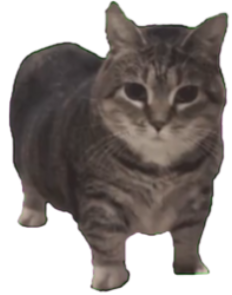
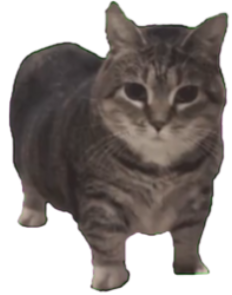
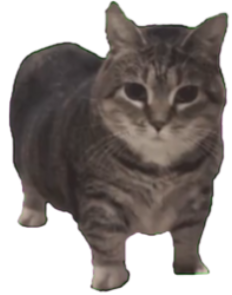
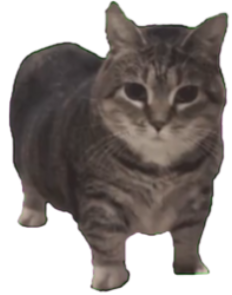
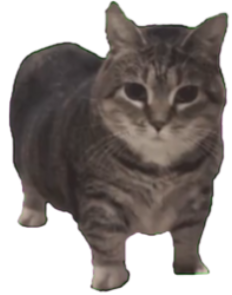
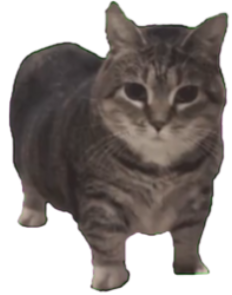
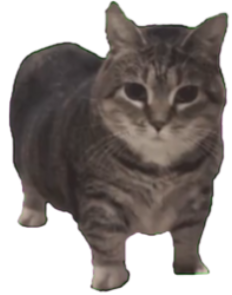
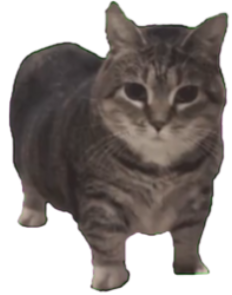
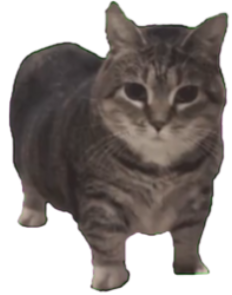
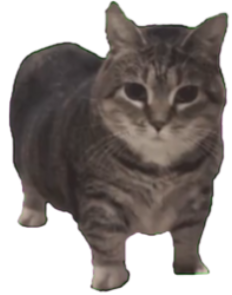
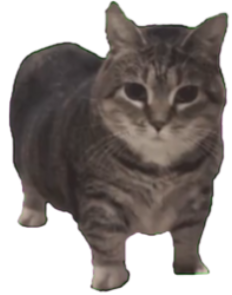
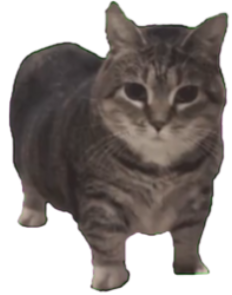
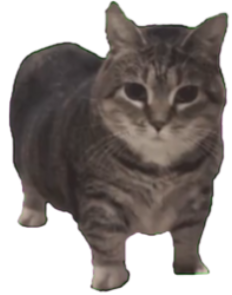
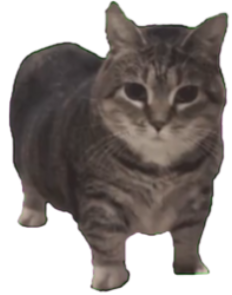
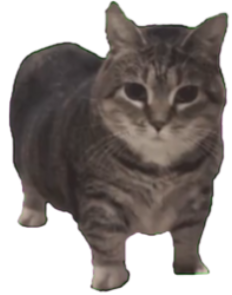
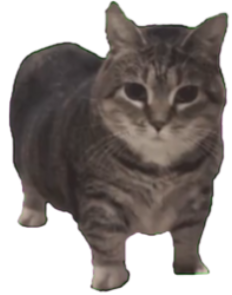
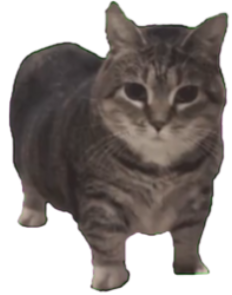
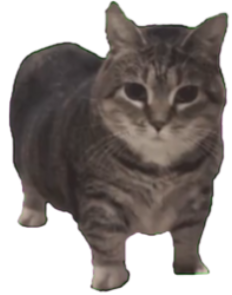
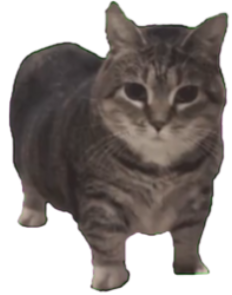
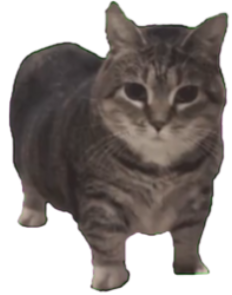
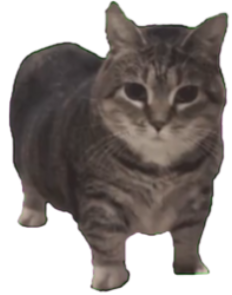
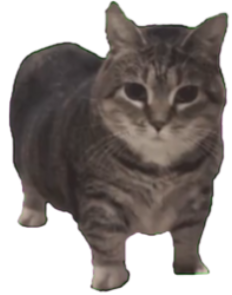
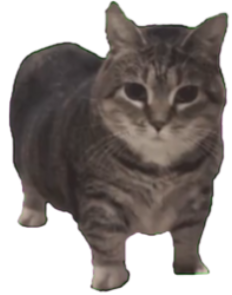
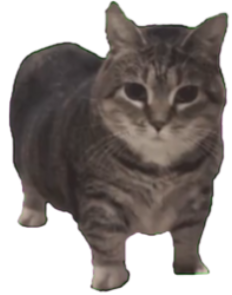
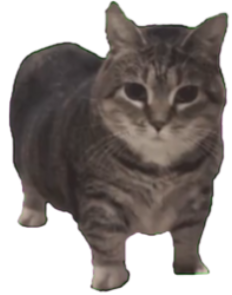
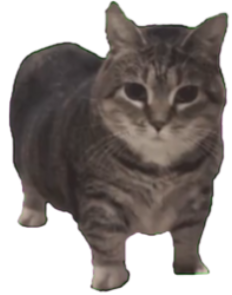
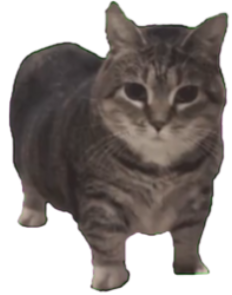
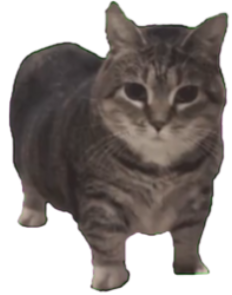
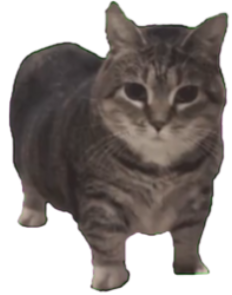
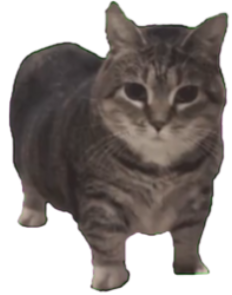
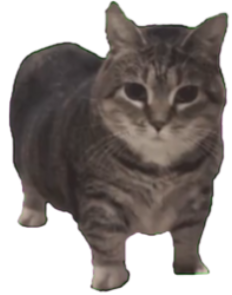
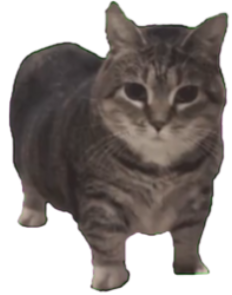
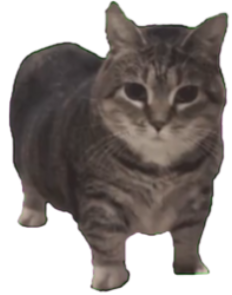
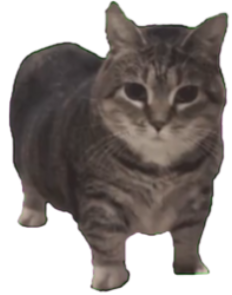

In [10]:
map_visualizer = MapVisualizer(city_data)
map_visualizer.display_initial_map()

### 🌐 Distance Visualization

In [11]:
distance_visualizer = DistanceVisualizer(city_data.distances, city_data)
distance_visualizer.display_distance_matrix(start_index=10, end_index=16)


Sample distance matrix (5x5):
[[  0.         116.86387579 407.23588814 430.28878745 665.16257259
   74.60268441]
 [116.86387579   0.         311.39222252 321.10258909 569.5398012
  182.69488794]
 [407.23588814 311.39222252   0.          90.23648427 258.70628214
  481.51029586]
 [430.28878745 321.10258909  90.23648427   0.         269.39700626
  501.83141917]
 [665.16257259 569.5398012  258.70628214 269.39700626   0.
  739.63019814]
 [ 74.60268441 182.69488794 481.51029586 501.83141917 739.63019814
    0.        ]]


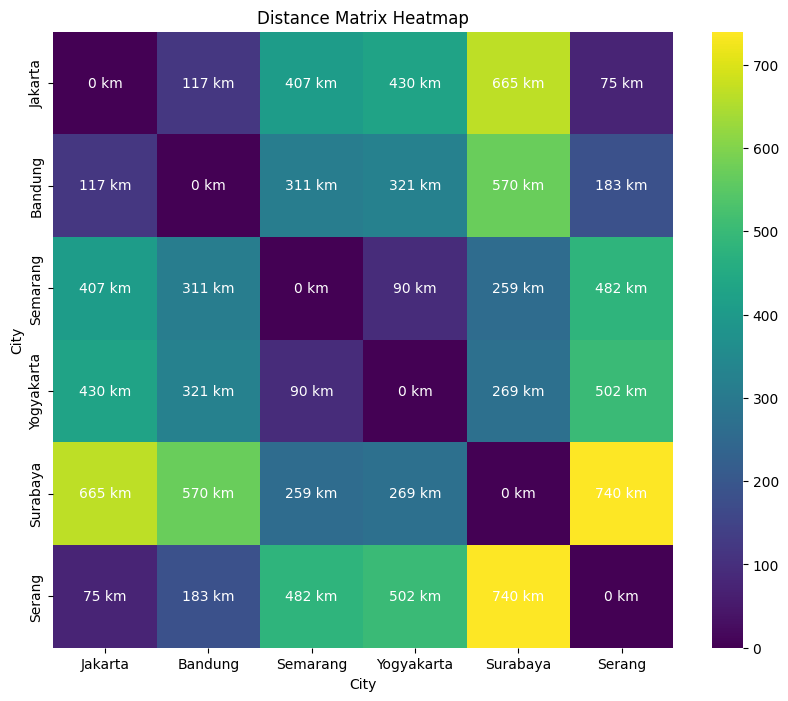

In [12]:
distance_visualizer.display_distance_heatmap(start_index=10, end_index=16)

## Hyperparameter Optimization and Best Params

### 🔧 Hyperparameter Optimizers

In [13]:
custom_param_grid = {
    'n_ants': [20], # Number of ants
    'n_iterations': [150], # Number of iterations
    'decay_rate': [0.5], # Pheromone decay rate
    'alpha': [1], # Alpha parameter
    'beta': [3] # Beta parameter
}

In [14]:
print("Starting hyperparameter optimization...")
hyperparameter_optimizer = HyperparameterOptimizer(city_data.distances)
best_params = hyperparameter_optimizer.optimize(custom_param_grid)

Starting hyperparameter optimization...
Iteration 1: Best path length = 20584.914789568338
Iteration 11: Best path length = 19491.673469995978
Iteration 21: Best path length = 16290.495808958702
Iteration 31: Best path length = 15559.054681441734
Iteration 41: Best path length = 15481.51215528905
Iteration 51: Best path length = 15481.51215528905
Iteration 61: Best path length = 15481.51215528905
Iteration 71: Best path length = 15293.812709639607
Iteration 81: Best path length = 15293.812709639607
Iteration 91: Best path length = 15293.812709639607
Iteration 101: Best path length = 15293.812709639607
Iteration 111: Best path length = 15293.812709639607
Iteration 121: Best path length = 15293.812709639607
Iteration 131: Best path length = 15293.812709639607
Iteration 141: Best path length = 15293.812709639607
Params : {'alpha': 1, 'beta': 3, 'decay_rate': 0.5, 'n_ants': 20, 'n_iterations': 150} | Score : 6.538591906318465e-05

Best Hyperparameters: {'alpha': 1, 'beta': 3, 'decay_rate':

### 🏆 Best Params

ACO with optimized hyperparameters

In [15]:
print("\nRunning ACO with optimized hyperparameters...")
aco = AntColonyOptimizer(
    city_data.distances,
    n_ants=best_params["n_ants"],
    n_iterations=best_params["n_iterations"],
    decay_rate=best_params["decay_rate"],
    alpha=best_params["alpha"],
    beta=best_params["beta"],
)
best_path = aco.optimize()


Running ACO with optimized hyperparameters...
Iteration 1: Best path length = 21305.489787107017
Iteration 11: Best path length = 18914.33747647152
Iteration 21: Best path length = 15652.930562059742
Iteration 31: Best path length = 15080.824993719107
Iteration 41: Best path length = 15080.824993719107
Iteration 51: Best path length = 15080.824993719107
Iteration 61: Best path length = 15080.824993719107
Iteration 71: Best path length = 15080.824993719107
Iteration 81: Best path length = 15033.170686415697
Iteration 91: Best path length = 15033.170686415697
Iteration 101: Best path length = 15033.170686415697
Iteration 111: Best path length = 15033.170686415697
Iteration 121: Best path length = 15033.170686415697
Iteration 131: Best path length = 15033.170686415697
Iteration 141: Best path length = 15033.170686415697


## Final Result Display

### 🗺️ Best Path Route Map


Visualizing the best path...



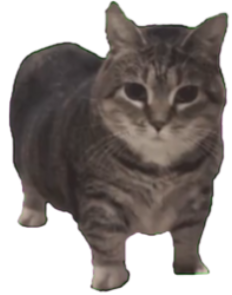
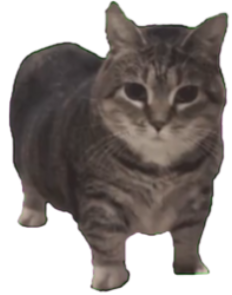
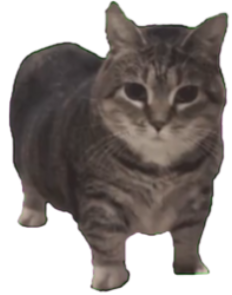
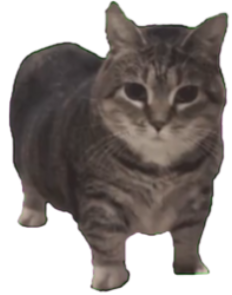
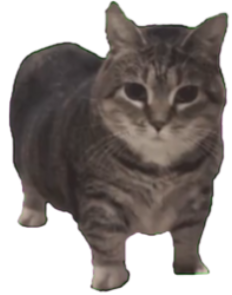
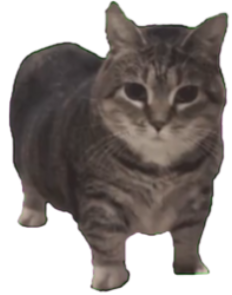
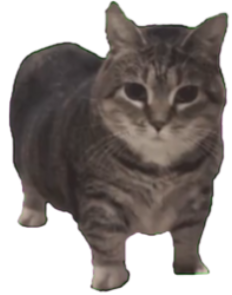
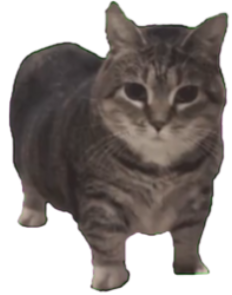
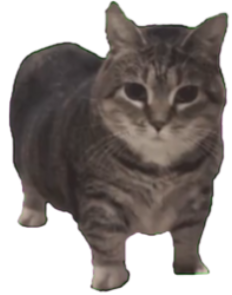
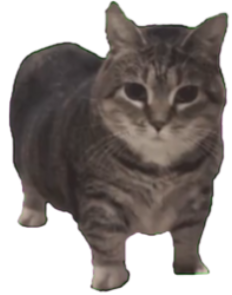
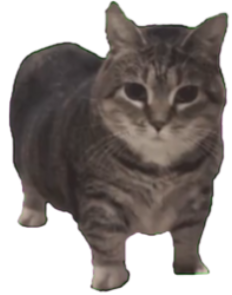
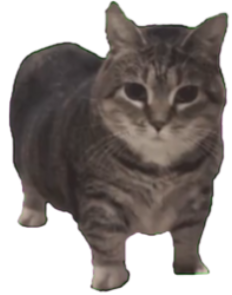
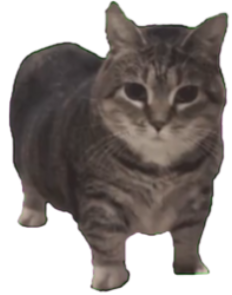
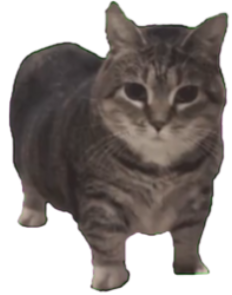
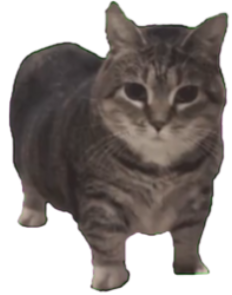
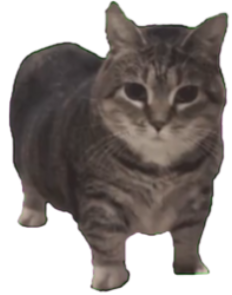
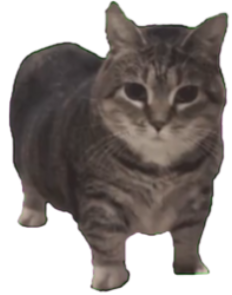
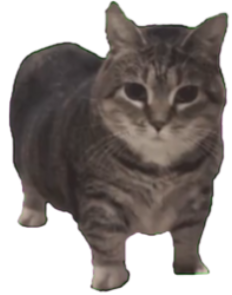
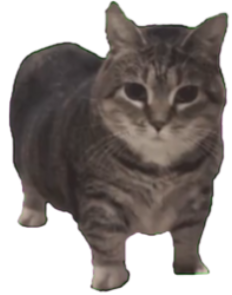
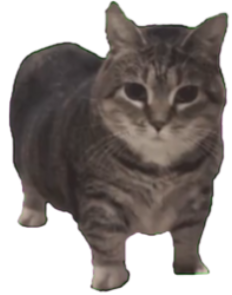
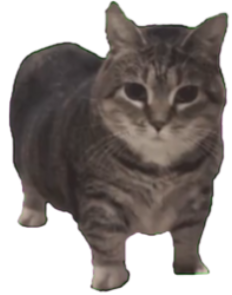
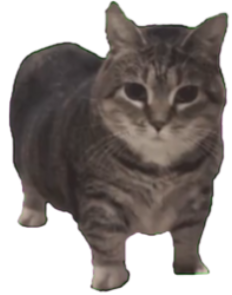
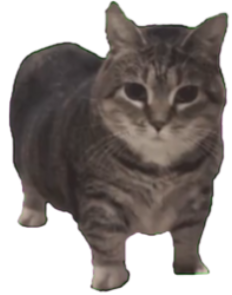
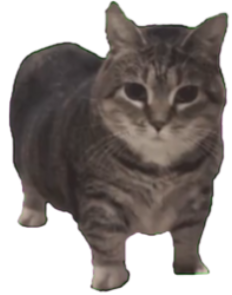
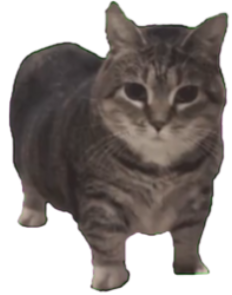
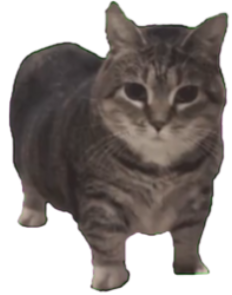
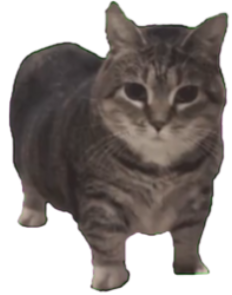
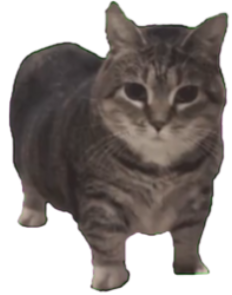
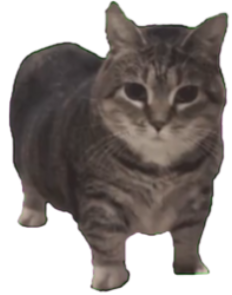
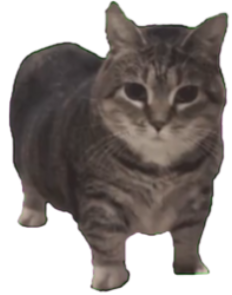
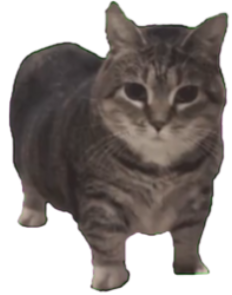
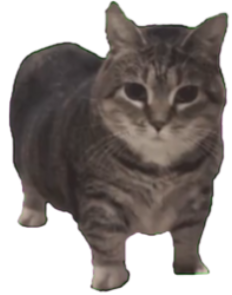
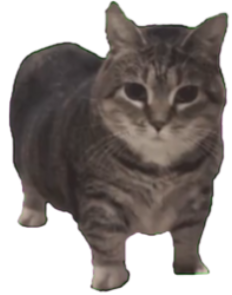
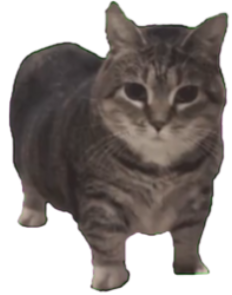
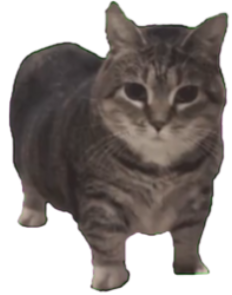
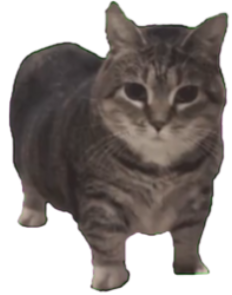
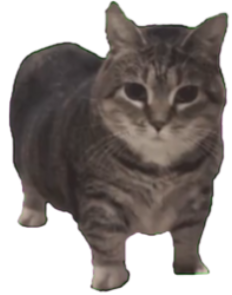
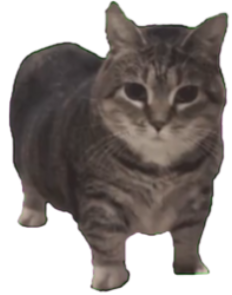
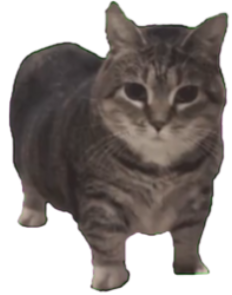

In [16]:
map_visualizer.visualize_path(best_path)

### 👣 Sequence of Visited Capital Cities

In [17]:
result_display = ResultDisplay(city_data, city_data.distances)
result_display.display_result(best_path)

Number       City Name              Province Name Distance (km)
0      01       Pekanbaru                       Riau     457.16 km
1      02           Medan             Sumatera Utara     431.10 km
2      03      Banda Aceh                       Aceh    1136.60 km
3      04  Tanjung Pinang             Kepulauan Riau     295.37 km
4      05           Jambi                      Jambi     199.83 km
5      06       Palembang           Sumatera Selatan     179.39 km
6      07  Pangkal Pinang  Kepulauan Bangka Belitung     428.33 km
7      08       Pontianak           Kalimantan Barat     564.38 km
8      09    Palangkaraya          Kalimantan Tengah     144.12 km
9      10     Banjarmasin         Kalimantan Selatan     423.38 km
10     11       Samarinda           Kalimantan Timur     370.56 km
11     12   Tanjung Selor           Kalimantan Utara     503.06 km
12     13            Palu            Sulawesi Tengah     226.89 km
13     14          Mamuju             Sulawesi Barat     280.87 km
14     15        Makassar           Sulawesi Selatan     368.85 km
15     16         Kendari          Sulawesi Tenggara     502.60 km
16     17       Gorontalo                  Gorontalo     225.30 km
17     18          Manado             Sulawesi Utara     357.83 km
18     19          Sofifi               Maluku Utara     406.84 km
19     20          Sorong           Papua Barat Daya     313.32 km
20     21       Manokwari                Papua Barat     320.59 km
21     22          Nabire               Papua Tengah     394.79 km
22     23      Jayawijaya           Papua Pegunungan     257.46 km
23     24        Jayapura                      Papua     662.56 km
24     25         Merauke              Papua Selatan    1451.51 km
25     26           Ambon                     Maluku     881.04 km
26     27          Kupang        Nusa Tenggara Timur     836.20 km
27     28         Mataram        Nusa Tenggara Barat      98.16 km
28     29        Denpasar                       Bali     313.40 km
29     30        Surabaya                 Jawa Timur     258.71 km
30     31        Semarang                Jawa Tengah      90.24 km
31     32      Yogyakarta              DI Yogyakarta     321.10 km
32     33         Bandung                 Jawa Barat     116.86 km
33     34         Jakarta                DKI Jakarta      74.60 km
34     35          Serang                     Banten     125.51 km
35     36  Bandar Lampung                    Lampung     379.13 km
36     37        Bengkulu                   Bengkulu     381.07 km
37     38          Padang             Sumatera Barat     203.72 km


Total distance: 14982.44 km
